# Simple GAN: Theory

The generative model is pitted against an adversary: a discriminative model that learns to determine whether a sample is from the generative model distribution or the data distribution.

**Setup**<br>
* $p_{data}$: true data distribution over data $\mathbf{x}\in\mathcal{X}$.
* $p_g$: generators distribution over data $\mathbf{x}\in\mathcal{X}$.
* $p_{\mathbf{z}}(\mathbf{z})$: prior on input noise variables $\mathbf{z}\in\mathcal{Z}$
* Let $G:\mathcal{Z}\rightarrow\mathcal{X}$ be the generator $G(\mathbf{z};\theta_g)$
* Let $D:\mathcal{X}\rightarrow[0,1]$ be the discriminator $D(\mathbf{x};\theta_d)$, where $D(\mathbf{x})$ is the probability that $\mathbf{x}$ came from the data distribution $p_{data}$ than the generator distribution $p_g$.

**The Objective Function**<br>
$D$ and $G$ play the following two-player minimax game with the value function $V(D,G)$

$$\underset{G}{\text{min }}\underset{D}{\text{max }}V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]$$

where 
* We would like to maximise the first term as this is the probability (output by model $D$) of the data point $\mathbf{x}\sim p_{data}$ coming from the data distribution $p_{data}$.
* We would like to minimise the second term as this is the probability (output by model $D$) that the data point $G(\mathbf{z})$ comes from the generative model distribution $p_g$.

In practice, the original loss function may not provide sufficient gradients for $G$ to learn. This is because early in learning, $G$ is poor and $D$ can easily reject samples with high confidence such that $\log\Big(1-D\big(G(\mathbf{z})\big)\Big)\rightarrow0$ as $D\big(G(\mathbf{z})\big)\approx0$. Instead we can use the below loss function,

$$\underset{G}{\text{max }}\underset{D}{\text{max }}V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\Big[\log D\big(G(\mathbf{z})\big)\Big]$$

which has the same fixed point of the dynamics of $G$ and $D$ but provides much stronger gradients early in learning.

**Convegence Results**<br>
In this setup, for $G$ fixed the optimal discriminator $D$ is 

$$D^{\star}_{G}(\mathbf{x})=\frac{p_{data}(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}$$

The training objective for $D$ can be interpreted as maximising the log-likelihood of the conditional probabiltiy $p(Y=y\mid \mathbf{x})$, where $y=1$ if $\mathbf{x}$ comes from $p_{data}$ and $y=0$ if $\mathbf{x}$ comes from $p_g$. The objective can be reformulated as,

$$\begin{align}
V(D^{\star}_G,G)&=\underset{D}{\text{max }}V(D,G)\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D^{\star}_G(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D^{\star}_G\big(G(\mathbf{z})\big)\Big)\bigg]\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D^{\star}_G(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D^{\star}_G(\mathbf{x})\Big)\bigg]\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\bigg[\log\frac{p_{data}(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}\bigg]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log\frac{p_g(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}\bigg]
\end{align}$$

The generator minimises the original objective for a fixed discriminator $D$. Hence the global minimum of the virtual training criterion $V(D^{\star}_G,G)$ is achieved if and only if $p_g=p_{data}$. This means that $D^{\star}_G=\frac{1}{2}$ such that

$$\begin{align}
V(D^{\star}_G,G)&=-\log4+KL\bigg(p_{data}||\frac{p_{data}+p_g}{2}\bigg)+ KL\bigg(p_g||\frac{p_{data}+p_g}{2}\bigg)\\
&=-\log4 + 2D_{JSD}(p_{data}||p_g)
\end{align}$$

where $D_{JSD}$ is the Jenson-Shannon Divergence (the symmetric form of the KL divergence). Since the Jensen–Shannon divergence between two distributions is always non-negative and zero only when they are equal, we that the optimal objective is $V(D^{\star}_{G^{\star}},G^{\star})=\underset{G}{\text{min }}V(D^{\star}_G,G)=-\log4$.

**The Training Algorithm**<br>
In practice, we must implement the game using an iterative, numerical approach. Optimizing $D$ to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. Instead, we alternate between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in $D$ being maintained near its optimal solution, so long as G changes slowly enough.

For epochs $1,...,N$ do:<br>
For k steps do:
1. Sample minibatch of size $m$ from data: $\mathbf{x}^{(1)},...,\mathbf{x}^{(m)}\sim p_{data}(\mathbf{x})$
2. Sample minibatch of size $m$ from noise: $\mathbf{z}^{(1)},...,\mathbf{z}^{(m)}\sim p_{\mathbf{z}}(\mathbf{z})$
3. Take a gradient ascent step on the discriminator parameters $\theta_d$

$$\nabla_{\theta_d}V(D,G)=\frac{1}{m}\nabla_{\theta_d}\sum^{m}_{i=1}\bigg[\log D\Big(\mathbf{x}^{(i)}\Big) +\log \Big(1-D\Big(G\Big(\mathbf{z}^{(i)}\Big)\Big)\Big)\bigg]$$

end for <br>
4. Sample minibatch of size $m$ from noise: $\mathbf{z}^{(1)},...,\mathbf{z}^{(m)}\sim p_{\mathbf{z}}(\mathbf{z})$
5. Take a gradient descent step on the generator parameters $\theta_g$

$$\nabla_{\theta_g}V(D,G)=\frac{1}{m}\nabla_{\theta_d}\sum^{m}_{i=1}\log \Big(1-D\Big(G\Big(\mathbf{z}^{(i)}\Big)\Big)\Big)$$

end for

**Challenges**<br>
Working with GANs in practice is challenging because:
1. Unstable optimisation procedure: generator and discriminator loss continue to oscillate without converging to clear stopping point.
2. Potential for mode collapse: generator can get stuck producing one of a few types of samples over and over again.
3. Difficulty in evaluation: due to the lack of a robust stopping criteria, it is difficult to know when exactly the GAN has finished training.

Tips and tricks for training a GAN: https://github.com/soumith/ganhacks

**References**<br>
Original GAN paper: https://arxiv.org/abs/1406.2661 <br>
NeurIPS GAN tutorial: https://arxiv.org/abs/1701.00160 <br>
CS236 notes: https://deepgenerativemodels.github.io/notes/index.html

# Simple GAN: Code

PyTorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN#gan<br>
https://github.com/BY571/GANs/blob/master/Basic%20GAN.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

## Load MNIST Dataset

In [2]:
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=False,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [-1,+1]
# x_train = ((x_train.float() / 255) - 0.5) * 2
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])

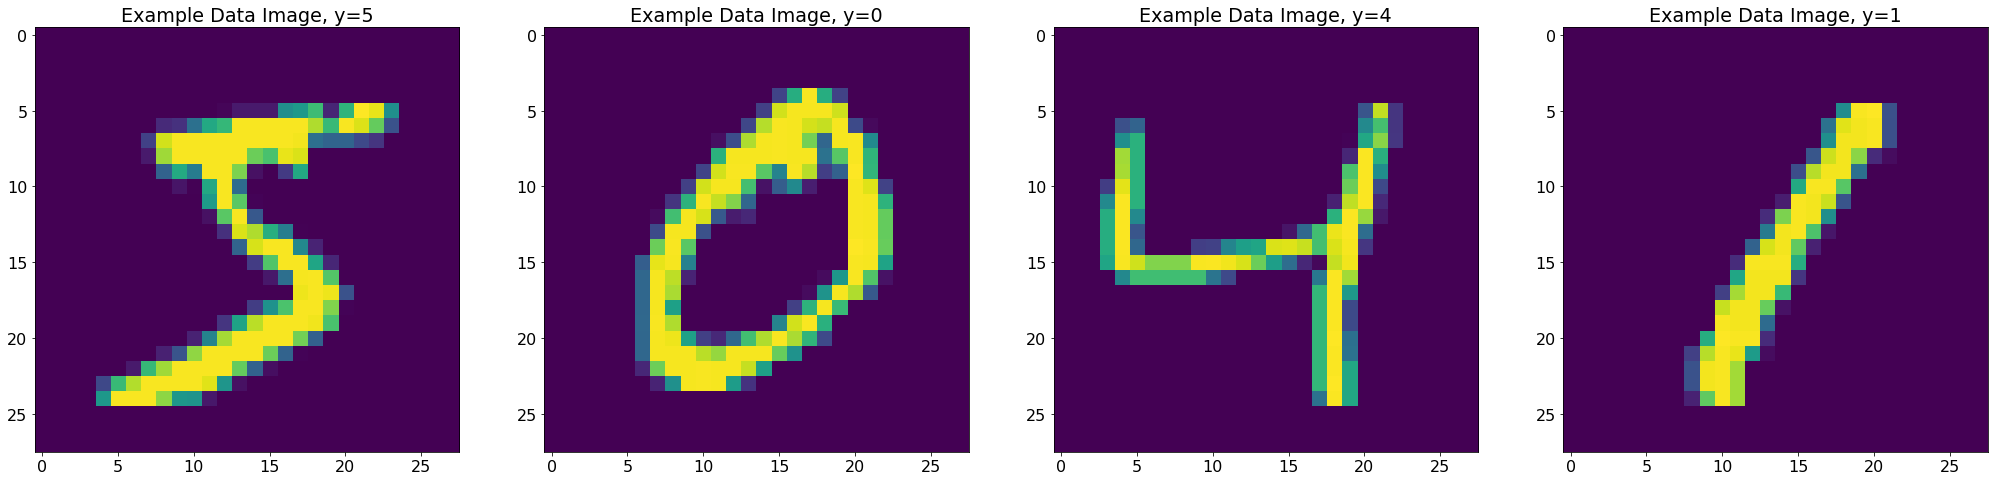

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=-1, vmax=1)
plt.show()

## Models

In [5]:
class Generator(nn.Module):
    def __init__(self, input_shape, output_shape):
        """
        Generator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Dimensionality of the latent space. (Default=100)
        output_shape : `int`
            Flattened size of image. (Default=784)
        """
        super(Generator, self).__init__()
        
        def block(in_shape, out_shape, normalize=True):
            layers = [nn.Linear(in_shape, out_shape)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_shape, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers        
        
        self.model = nn.Sequential(*block(input_shape, 128, normalize=False),
                                   *block(128, 128),
                                   nn.Linear(128, output_shape),
                                   nn.Tanh())

    def forward(self, z):
        x = self.model(z)
        x = x.view(x.size(0), *x_shape)
        return x        

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        """
        Discriminator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Flattened size of image. (Default=784)
        """        
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_shape, 128),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(128, 128),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(128, 1),
                                   nn.Sigmoid())

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        y = self.model(x_flat)
        return y

## Training

In [7]:
# Hyperparameters
z_dim   = 100
epochs  = 1
batch_size = 64
k = 1

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create DatatLoader 
dataset = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator     = Generator(z_dim, np.prod(x_train[0].shape))
discriminator = Discriminator(np.prod(x_train[0].shape))

# Send to GPU if available 
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Optimisers
optimiser_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimiser_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)

print("Device: ", device)
print(generator)
print(discriminator)

Device:  cpu
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=128, out_features=784, bias=True)
    (6): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
# Training

measures = defaultdict(list)
measures['loss_d']
measures['loss_g']

start_time = time.time()
for epoch in range(epochs):
    
    for step in range(k):    
        # Train Discriminator
        for i, (X,y) in enumerate(dataloader):
            
            # Adversarial ground truths
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)            
            
            optimizer_D.zero_grad()
            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            batches_done = epoch * len(dataloader) + i
            if batches_done % opt.sample_interval == 0:
                save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)            
    
    # Train Generator
    for i, (X,y) in enumerate(dataloader):
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)           
        
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()    